In [47]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from synthetic_data import UpliftDataSet

In [48]:
dataset = UpliftDataSet(age_min = 16,
                        age_max = 60,
                        n_cities = 6,
                        n_users = 100000,
                        share_negative_people=0.01)
data_from_experiment = dataset.get_train(sorted_type_of_communication=(5,10,15), 
                                         subsample_for_train=0.3,
                                         share_communicate=0.75,
                                         n_days = 1)
train, valid = train_test_split(data_from_experiment, test_size=0.3, 
                                shuffle=True, stratify=data_from_experiment["communication"])
users = dataset.get_user_data

### Two models

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ['day', 'age']),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ['gender', 'city', 'communication']),
    ]
)
full_model = Pipeline([('preprocessing', preprocessor),
                       ('model', LinearRegression())])

x = train[['gender','age','city','day', 'communication']]
y = train['purchases']

model =  deepcopy(full_model).fit(x, y)

### Metrics

##### uplift@k

In [50]:
k = 10

valid_ = valid.copy()
valid_['purchases'] = valid_['purchases']*(1-valid_['communication']/100)
communications = train['communication'].unique()
true_communication = valid_['communication'].copy()
for key in communications:
    valid_['communication'] = key
    valid_[key] = model.predict(valid_[['gender','age','city','day', 'communication']])*(1-key/100)
valid_['communication'] = true_communication

uplift_metric = {}
for key in [x for x in communications if x != 0]:
    valid_[key] = valid_[key] - valid_[0]
    sorted_values = valid_[valid_['communication'] == key].sort_values(key, ascending=False)
    sorted_values_0 = valid_[valid_['communication'] == 0].sort_values(key, ascending=False)
    uplift_metric[key] = sorted_values['purchases'].head(k).sum() - sorted_values_0['purchases'].head(k).sum()
uplift_metric

{15.0: 22.66206754511785, 5.0: 53.053359620146296, 10.0: 119.17549807278786}

##### uplift by percentile (or uplift by bin, uplift by decile)

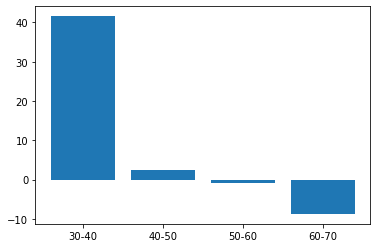

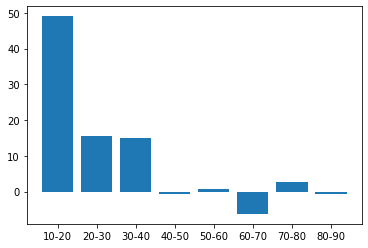

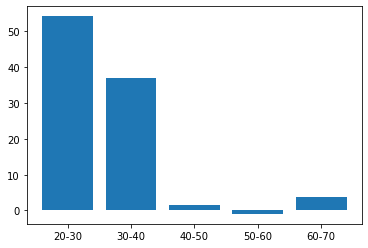

In [51]:
valid_ = valid.copy()
valid_['purchases'] = valid_['purchases']*(1-valid_['communication']/100)
communications = train['communication'].unique()
for key in communications:
    valid_[key] = model.predict(valid_[['gender','age','city','day', 'communication']])*(1-key/100)
    
    if key != 0:
        sabsample = valid_[valid_['communication'].isin([0, key])]
        percentiles_value = sabsample[key].quantile(np.linspace(0,1,11))
        # if there are percentiles with the same value, we have to collapse them
        percentiles_value = percentiles_value[percentiles_value != percentiles_value.shift()]
        # let's generate names
        percentile_names = [f"{x*100:.0f}".zfill(2) for x in percentiles_value.index]
        percentile_names = [x + '-' + y for x, y in zip(percentile_names[:-1], percentile_names[1:])]
        valid_[f"{key} bin"] = pd.cut(valid_[key], bins=percentiles_value, 
                               include_lowest=True, labels=percentile_names[::-1]).astype(str)
for key in [x for x in communications if x != 0]:
    vals = (valid_[valid_['communication'] == key].groupby(f"{key} bin")['purchases'].mean() 
            - valid_[valid_['communication'] == 0].groupby(f"{key} bin")['purchases'].mean()
           ).sort_index()

    plt.bar(vals.index, vals)
    plt.show()

### to be continued...